#Importing libraries

In [ ]:
# Mount Google Drive for Google Colab
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/ESP4901_FYP'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/ESP4901_FYP
/content/gdrive/My Drive/ESP4901_FYP


In [5]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, ZeroPadding2D, Convolution2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Create train, validation and test set

In [ ]:
def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the dataset.

    Return:
      Class that the file belongs to.
  """
  part = fname.split('.')[0].split('-')
  emotion = part[2]
  if emotion == '01':
    return 'neutral'
  elif emotion == '02':
    return 'calm'
  elif emotion == '03':
    return 'happy'
  elif emotion == '04':
    return 'sad'
  elif emotion == '05':
    return 'angry'
  elif emotion == '06':
    return 'fear'
  elif emotion == '07':
    return 'disgust'
  elif emotion == '08':
    return 'surprise'

In [ ]:
import os
import random

directory_files = os.listdir('/content/gdrive/My Drive/ESP4901_FYP/RAVDESS')
random.shuffle(directory_files)

female = list()
male = list()
for files in directory_files:
  part = files.split("_")[1]
  if int(part) % 2 == 0:
    female.append(files)
  else:
    male.append(files)
    
random.shuffle(female)
random.shuffle(male)
train = female[0:8] + male[0:8]
val = female[8:10] + male[8:10]
test = female[10:12] + male[10:12]
print(train)
print(val)
print(test)

In [ ]:
import shutil
import os.path
from os import path

for actor in train:
  curr_path = '/content/gdrive/My Drive/ESP4901_FYP/RAVDESS/' + actor
  directory_files = os.listdir(curr_path)
  for files in directory_files:
      old_path = curr_path + '/' + files
      folder = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_train_2/'
      new_path = folder + get_class(files) + '/'

      if path.exists(folder) == False:
        os.mkdir(folder)
  
      if path.exists(new_path) == False:
        os.mkdir(new_path)

      shutil.copy(old_path, new_path + files)

for actor in val:
  curr_path = '/content/gdrive/My Drive/ESP4901_FYP/RAVDESS/' + actor
  directory_files = os.listdir(curr_path)
  for files in directory_files:
      old_path = curr_path + '/' + files
      folder = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_val_2/'
      new_path = folder + get_class(files) + '/'

      if path.exists(folder) == False:
        os.mkdir(folder)
  
      if path.exists(new_path) == False:
        os.mkdir(new_path)

      shutil.copy(old_path, new_path + files)

for actor in test:
  curr_path = '/content/gdrive/My Drive/ESP4901_FYP/RAVDESS/' + actor
  directory_files = os.listdir(curr_path)
  for files in directory_files:
      old_path = curr_path + '/' + files
      folder = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_test_2/'
      new_path = folder + get_class(files) + '/'

      if path.exists(folder) == False:
        os.mkdir(folder)
  
      if path.exists(new_path) == False:
        os.mkdir(new_path)

      shutil.copy(old_path, new_path + files)

#Data Analysis

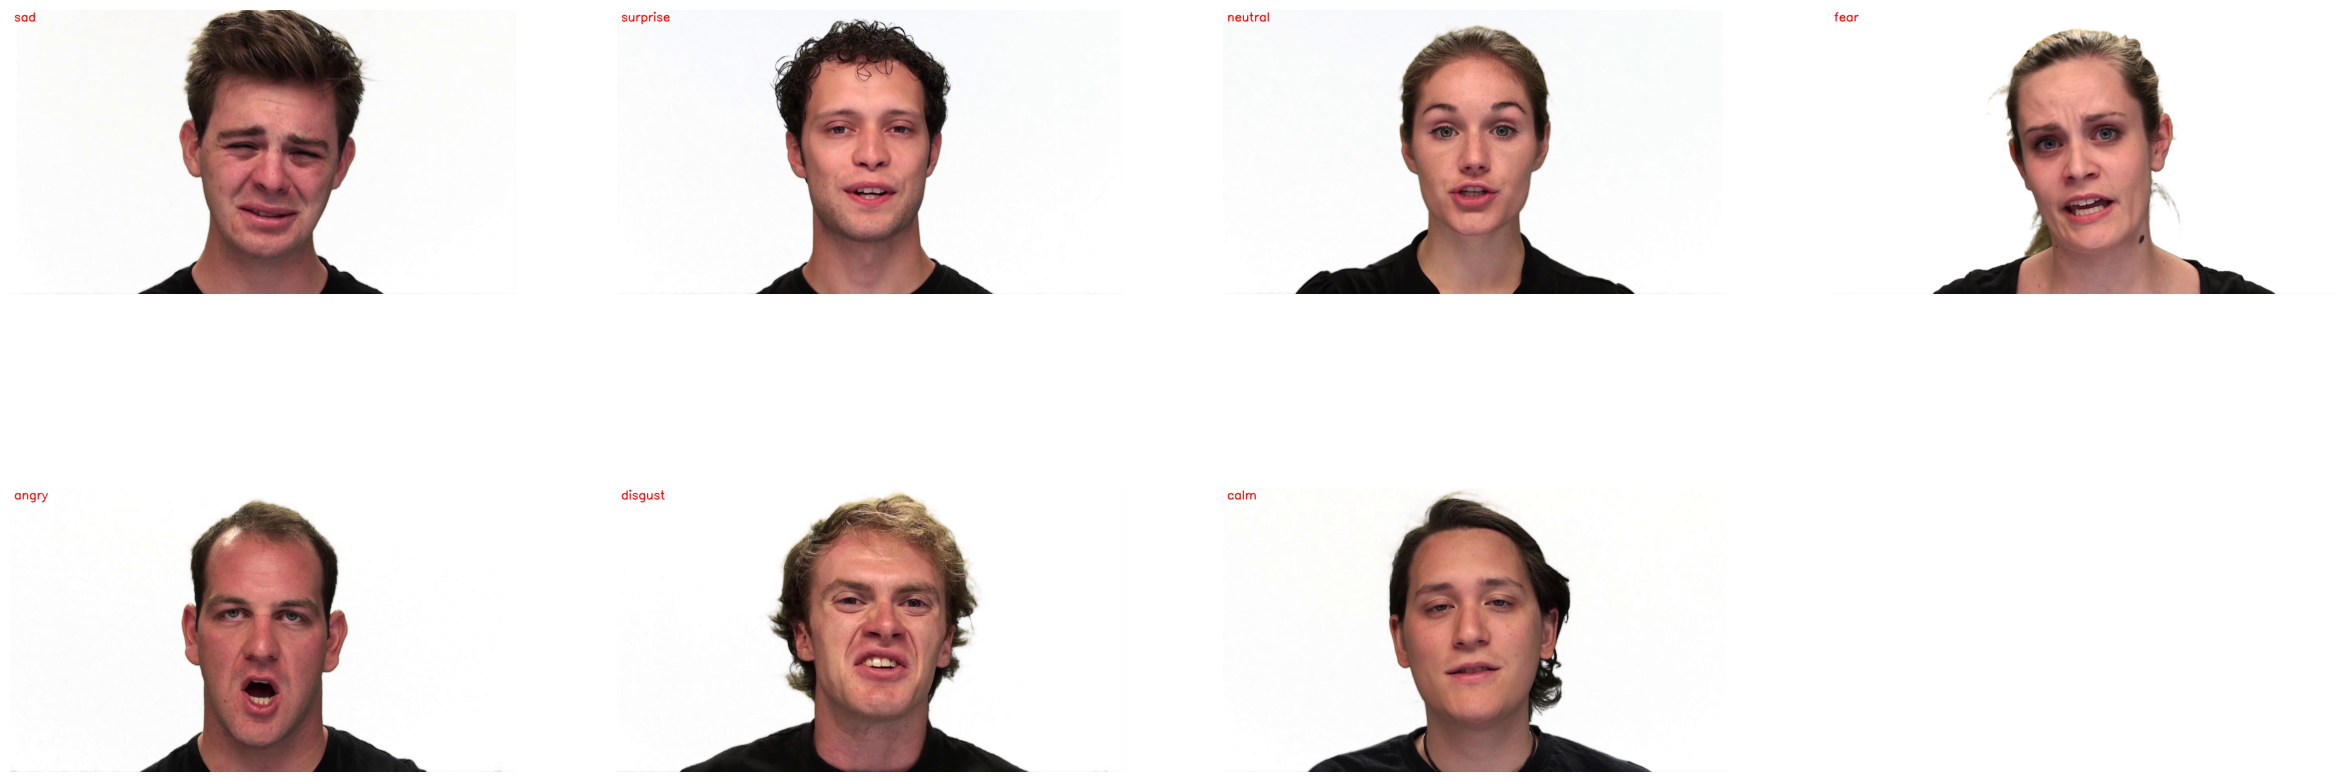

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Get Names of all classes in UCF50
train_path = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_train_2/'
val_path = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_val_2/'
test_path = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_test_2/'
all_classes_names = os.listdir(train_path)
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)),7)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{train_path}{selected_class_Name}')
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'{train_path}{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    frame=45
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame)
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
train_ds_directory = train_path
classes_list = sorted(os.listdir(train_path))
print(classes_list)

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


#Pre-process dataset

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.5 MB/s eta 0:00:00


In [ ]:
from matplotlib import pyplot as plt
import torchvision.transforms as T
from PIL import Image
from facenet_pytorch import MTCNN
import math

mtcnn = MTCNN(image_size=224)

def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
     
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    frameRate = video_reader.get(5)
    # Iterating through Video Frames
    while True:
        frameId = video_reader.get(1)
        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        if (frameId % math.floor(frameRate) == 0):
          # Face detection with MTCNN
          rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          frame = Image.fromarray(rgb_frame)
          face = mtcnn(frame)

          # If face is not detected
          if (face == None):
              break
          
          #Gray-scaled
          #transform = T.Grayscale()
          #face = transform(face).permute(1,2,0).numpy()
          #face = np.expand_dims(face, axis=-1)

          face = face.permute(1,2,0).numpy()
          #print(face.shape)
          #plt.imshow(face)
          #plt.axis("off")
          #plt.show()

          # Appending the normalized frame into the frames list
          frames_list.append(face)
    
    #print(len(frames_list))
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
    #print(len(frames_list))
    
    # returning the frames list 
    return frames_list

In [ ]:
#Testing if face detection works
video_path = "/content/gdrive/My Drive/ESP4901_FYP/RADVESS_train_2/angry/02-01-05-01-01-01-02.mp4"
frames_extraction(video_path)

In [ ]:
def create_dataset(dataset_directory):
 
    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
     
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
         
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
 
        # Iterating through all the files present in the files list
        for file_name in files_list:
 
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
 
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
 
            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        max_images_per_class = len(temp_features)
        # Adding randomly selected frames to the features list
        features.extend(temp_features)
 
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
         
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
 
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
 
    return features, labels

In [ ]:
features_train, labels_train = create_dataset(train_path)
print(features_train.shape)

Extracting Data of Class: angry
Extracting Data of Class: calm
Extracting Data of Class: disgust
Extracting Data of Class: fear
Extracting Data of Class: happy
Extracting Data of Class: neutral
Extracting Data of Class: sad
Extracting Data of Class: surprise
(4063, 224, 224, 3)


In [ ]:
features_val, labels_val = create_dataset(val_path)
print(features_val.shape)

Extracting Data of Class: angry
Extracting Data of Class: calm
Extracting Data of Class: disgust
Extracting Data of Class: fear
Extracting Data of Class: happy
Extracting Data of Class: neutral
Extracting Data of Class: sad
Extracting Data of Class: surprise
(1025, 224, 224, 3)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((features_train, labels_train))
val_ds = tf.data.Dataset.from_tensor_slices((features_val, labels_val))

In [ ]:
batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size = AUTOTUNE)

#VGG-face Pre-trained model

In [1]:
!pip install keras_vggface
!pip install keras_applications --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.2 MB/s eta 0:00:00


In [2]:
pip show keras_vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: h5py, keras, numpy, pillow, pyyaml, scipy, six
Required-by: 


In [3]:
filename = "/usr/local/lib/python3.9/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

In [6]:
vggface = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')
for layer in vggface.layers:
    layer.trainable = False

x = vggface.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='softmax')(x)


model = keras.Model(inputs=vggface.input, outputs=x)

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best_vgg.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [ ]:
history_vgg = model.fit(x=train_ds,
                 validation_data=val_ds,
                 epochs=200,
                 callbacks=[checkpointer])

Epoch 1/200
63/64 [============================>.] - ETA: 0s - loss: 2.1096 - accuracy: 0.1324
Epoch 1: val_accuracy improved from -inf to 0.23610, saving model to model.weights.best_vgg.hdf5
64/64 [==============================] - 6s 73ms/step - loss: 2.1097 - accuracy: 0.1317 - val_loss: 2.0518 - val_accuracy: 0.2361
Epoch 2/200
63/64 [============================>.] - ETA: 0s - loss: 2.0675 - accuracy: 0.1882
Epoch 2: val_accuracy improved from 0.23610 to 0.30829, saving model to model.weights.best_vgg.hdf5
64/64 [==============================] - 4s 60ms/step - loss: 2.0676 - accuracy: 0.1880 - val_loss: 2.0331 - val_accuracy: 0.3083
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 2.0526 - accuracy: 0.2024
Epoch 3: val_accuracy improved from 0.30829 to 0.34146, saving model to model.weights.best_vgg.hdf5
64/64 [==============================] - 4s 60ms/step - loss: 2.0525 - accuracy: 0.2028 - val_loss: 2.0161 - val_accuracy: 0.3415
Epoch 4/200
63/64 [=========

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

#From scratch

In [ ]:
# Define the input shape of the visual data
input_shape = (224, 224, 3)

# Initialize the model
model_scratch = keras.models.Sequential()

# Add the input layer
model_scratch.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# Add the convolutional layers
model_scratch.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# Add the fully connected layers
model_scratch.add(Flatten())
model_scratch.add(Dense(4096, activation='relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(4096, activation='relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(8, activation='softmax'))


In [ ]:
model_scratch.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best_tf.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [ ]:
history = model_scratch.fit(x=train_ds,
                 validation_data=val_ds,
                 epochs=200,
                 callbacks=[checkpointer])

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 2.9531 - accuracy: 0.3492
Epoch 1: val_accuracy improved from -inf to 0.14829, saving model to model.weights.best_tf.hdf5
64/64 [==============================] - 19s 149ms/step - loss: 2.9531 - accuracy: 0.3492 - val_loss: 2.2668 - val_accuracy: 0.1483
Epoch 2/200
63/64 [============================>.] - ETA: 0s - loss: 1.7169 - accuracy: 0.4008
Epoch 2: val_accuracy did not improve from 0.14829
64/64 [==============================] - 5s 76ms/step - loss: 1.7163 - accuracy: 0.4007 - val_loss: 2.9732 - val_accuracy: 0.1473
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 1.6261 - accuracy: 0.4313
Epoch 3: val_accuracy did not improve from 0.14829
64/64 [==============================] - 5s 76ms/step - loss: 1.6255 - accuracy: 0.4312 - val_loss: 3.7365 - val_accuracy: 0.1268
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 1.4965 - accuracy: 0.4732
Epoch 4: val_accuracy did not 

###Fine-Tuning

In [ ]:
vggface.trainable = True
for layer in vggface.layers[:-5]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
64/64 [==============================] - 5s 59ms/step - loss: 1.4174 - accuracy: 0.5417 - val_loss: 1.6636 - val_accuracy: 0.4254
Epoch 2/10
64/64 [==============================] - 4s 55ms/step - loss: 1.4139 - accuracy: 0.5378 - val_loss: 1.6633 - val_accuracy: 0.4205
Epoch 3/10
64/64 [==============================] - 4s 55ms/step - loss: 1.4119 - accuracy: 0.5447 - val_loss: 1.6636 - val_accuracy: 0.4195
Epoch 4/10
64/64 [==============================] - 4s 55ms/step - loss: 1.4047 - accuracy: 0.5469 - val_loss: 1.6634 - val_accuracy: 0.4166
Epoch 5/10
64/64 [==============================] - 4s 55ms/step - loss: 1.4005 - accuracy: 0.5503 - val_loss: 1.6636 - val_accuracy: 0.4166
Epoch 6/10
54/64 [========================>.....] - ETA: 0s - loss: 1.3764 - accuracy: 0.5747

KeyboardInterrupt: ignored

#Visualise results

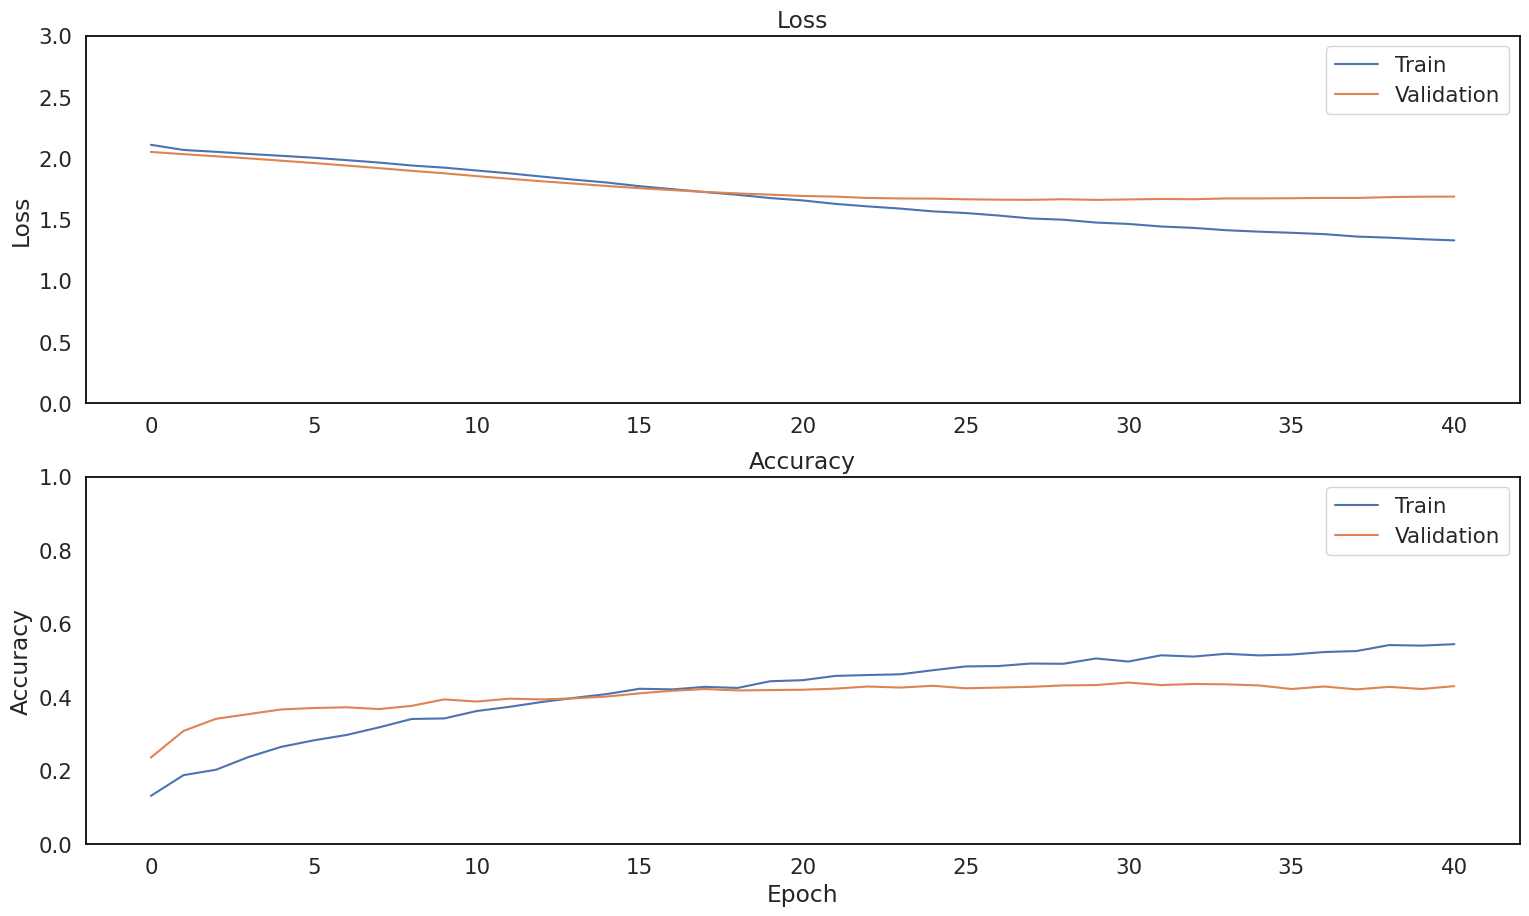

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  ax1.set_facecolor("white")

  for ax in [ax1, ax2]:
   plt.setp(ax.spines.values(), color='black')
   plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  #ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'], facecolor='white') 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'], facecolor='white')
  ax2.set_facecolor("white")

  plt.grid(False)
  plt.show()

plot_history(history_vgg)

In [ ]:
#save model
model.save("tf_model.h5")

#Evaluate result

In [ ]:
test_path = '/content/gdrive/My Drive/ESP4901_FYP/RADVESS_test_2/'

test_ds = []
test_ds_labels = []

for class_index, class_name in enumerate(classes_list):
  curr_path = test_path + class_name + '/'
  directory_files = os.listdir(curr_path)
  for files in directory_files:
    video_path = curr_path + files
    test_ds.append(video_path)
    test_ds_labels.append(class_index)
    

test_set = list(zip(test_ds, test_ds_labels))
random.shuffle(test_set)

In [ ]:
print(len(test_set))

240


In [ ]:
video_path = "/content/gdrive/My Drive/ESP4901_FYP/RADVESS_test_2/angry/02-01-05-01-01-01-01.mp4"

###VGG

In [ ]:
import numpy as np

# Initialize an empty array to store the predicted classes
predicted_classes = []
actual_labels = []

# Loop over each video in the test set
for video_path, labels in test_set:

    # Load the video frames and preprocess them
    frames = frames_extraction(video_path)
    # Pass the frames through the pre-trained CNN model to get the class predictions
    predictions = model.predict(tf.convert_to_tensor(frames))
    #print(predictions)
    
    # Converting Predicted Labels Probabilities into Numpy array
    predicted_labels_probabilities_np = np.array(predictions)

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Converting the predicted probabilities into labels by returning the index of the maximum value.
    predicted_label = np.argmax(predicted_labels_probabilities_averaged)

    # Add the predicted class to the list of predicted classes
    predicted_classes.append(predicted_label)
    actual_labels.append(labels)

    #print((predicted_classes, actual_labels))

# Compare the predicted classes with the actual labels to calculate the accuracy
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
accuracy_score(predicted_classes, actual_labels)*100

1/1 [==============================] - 0s 26ms/step


55.833333333333336

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

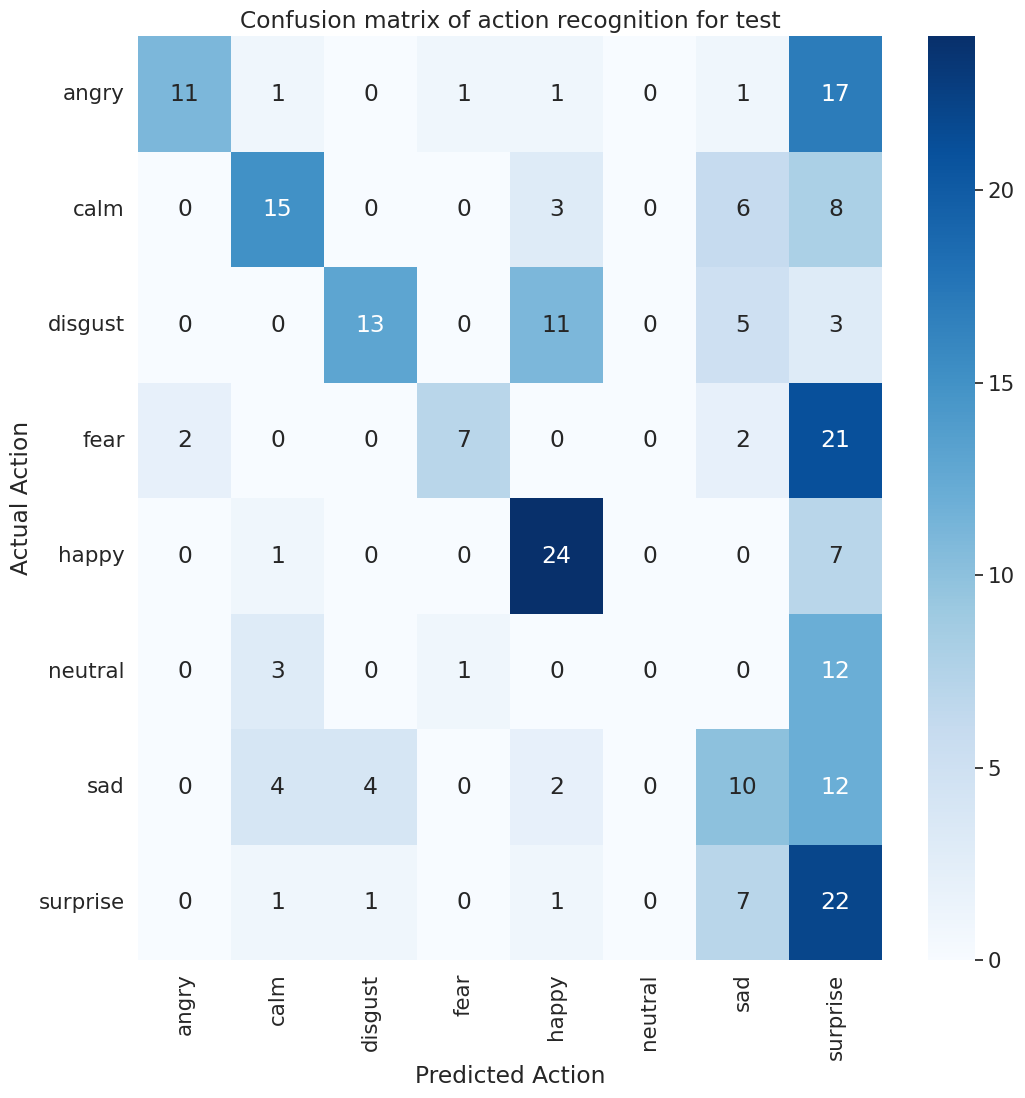

In [ ]:
#Test
plot_confusion_matrix(tf.convert_to_tensor(actual_labels), tf.convert_to_tensor(predicted_classes), classes_list, 'test')

###Model from scratch

In [ ]:
import numpy as np

# Initialize an empty array to store the predicted classes
predicted_classes = []
actual_labels = []

# Loop over each video in the test set
for video_path, labels in test_set:

    # Load the video frames and preprocess them
    frames = frames_extraction(video_path)
    # Pass the frames through the pre-trained CNN model to get the class predictions
    predictions = model_scratch.predict(tf.convert_to_tensor(frames))
    #print(predictions)
    
    # Converting Predicted Labels Probabilities into Numpy array
    predicted_labels_probabilities_np = np.array(predictions)

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Converting the predicted probabilities into labels by returning the index of the maximum value.
    predicted_label = np.argmax(predicted_labels_probabilities_averaged)

    # Add the predicted class to the list of predicted classes
    predicted_classes.append(predicted_label)
    actual_labels.append(labels)

    #print((predicted_classes, actual_labels))

# Compare the predicted classes with the actual labels to calculate the accuracy
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
accuracy_score(predicted_classes, actual_labels)*100

1/1 [==============================] - 0s 25ms/step


42.5